In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
%matplotlib inline
import sys
sys.path.append("/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Code")
np.set_printoptions(precision=5, suppress=True)

In [4]:
ds_path = '/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Survey+dataset/4_DNA_7values_regions_v2.csv'

df_DNA = pd.read_csv(ds_path)

In [5]:
#df_DNA

# Clustering


## Hierarchical Clustering

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.spatial.distance import cdist, pdist

### Dendogram and WSS/BSS

In [7]:
def PlotDendrogram(Z, title="", save_path=None):
    plt.figure(figsize=(25, 10))
    font = {'family' : 'sans', 'size'   : 18}
    plt.rc('font', **font)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Merge Distance')
    dendrogram(Z, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.xticks([])
    plt.show()

    plt.savefig(save_path)

In [8]:
def ComputeWSSBSS(X,Z,k_values=range(1,20)):
    wss_values = []
    bss_values = []

    for k in k_values:
        clustering = fcluster(Z, k, criterion='maxclust')
        frequency = np.bincount(clustering)
        index = np.nonzero(frequency)[0]
        
        centroids = [np.mean(X[clustering==c],axis=0) for c in index]
        
        cdist(X, centroids, 'euclidean')
        D = cdist(X, centroids, 'euclidean')
        cIdx = np.argmin(D,axis=1)
        d = np.min(D,axis=1)

        avgWithinSS = sum(d)/len(X)

        # Total with-in sum of square
        wss = sum(d**2)

        tss = sum(pdist(X)**2)/len(X)

        bss = tss-wss

        wss_values += [wss]
        bss_values += [bss]
    return wss_values,bss_values

In [9]:
def PlotKneeElbow(bss_values,wss_values,k_values,title="", save_path=None):
    fig = plt.figure(figsize=(24,12))
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
    plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('BSS & WSS')
    plt.xticks(k_values)
    plt.legend()
    plt.title(title);

    plt.savefig(save_path)

# Silohuette analisys

In [10]:
range_n_clusters = range(2,4)
algo = "HC"
sep = "_"
metric = "VDM"
vars = 8
regions = True
if vars != 7:
  regions = False
if_regions = "_regions" if regions else ""

postprocessing = True
is_postprocessing = "_fix" if postprocessing else ""

file_type = ".npy"
HC_base_path = "/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Code/Data/HC/"
linkages = ["single", "complete", "average", "weighted"]#, "ward", "centroid", "median"]
# linkages = ["ward"]
#silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list = getSilhouette(range_n_clusters, link=link)

In [11]:
# may cause RAM issues
distance_matrix = np.load(f"/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Code/Data/distance_matrix_{metric}{vars}{if_regions}.npy")

In [20]:
from sklearn.metrics import silhouette_score#, silhouette_samples
import matplotlib.cm as cm
from metrics.silhouette import getSilhouette

def getSilhouetteFromRange(range_n_clusters, link, postprocessing=False, patience=20):
  silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list = [], [], []
  
  prev_score = 0.0
  to_patience = 0
  for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer with n_clusters value
    link_file_type = '.npy'
    HC_path = f"{HC_base_path}{metric}{vars}{if_regions}/{algo}_{metric}_{link}{link_file_type}"
    Z = {}
    Z[metric] = np.load(HC_path)
    cluster_labels = fcluster(Z[metric], n_clusters, criterion='maxclust')
    
    if len(np.unique(cluster_labels)) >= 2:
      
      silhouette_avg, sample_silhouette_values, cluster_labels = getSilhouette(distance_matrix, cluster_labels, postprocessing)
        
      cluster_labels_list.append(cluster_labels)
      silhouette_avg_list.append(silhouette_avg)
      sample_silhouette_values_list.append(sample_silhouette_values)
      

      # Early stopping
      if silhouette_avg > prev_score:
        prev_score = silhouette_avg
        to_patience = 0
      else:
        prev_score = silhouette_avg
        if to_patience > patience:
          print(f"Early stopping after {patience} iterations...")
          break
        to_patience += 1
    else:
      print("For n_clusters =", n_clusters,
            "You got only 1 cluster!")
  return silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list

In [13]:
for link in linkages:
  print(f"Link: {link}")
  #silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list = getSilhouetteFromRange(range_n_clusters, link=link, postprocessing=True)

Link: single
Link: complete
Link: average
Link: weighted


# Define plot silhouette

In [14]:
def plot_silohuette_HC(range_n_clusters, silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list, save_path=None):
  
  max_n_clusters = range_n_clusters[-1]
  height = int(np.floor(7 * max_n_clusters/10))
  fig, ax = plt.subplots(len(range_n_clusters), figsize=(7,height*len(range_n_clusters)))
  plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data"),
                  fontsize=14, fontweight='bold')
  
  for ix, n_clusters in enumerate(range_n_clusters):
      # Create a subplot with 1 row and 2 columns
      #ax[i].set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax[ix].set_xlim([-1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax[ix].set_ylim([0, len(df_DNA) + (n_clusters + 1) * 10])

      # Silohuette for n_clusters
      cluster_labels = cluster_labels_list[ix]
      silhouette_avg = silhouette_avg_list[ix]
      sample_silhouette_values = sample_silhouette_values_list[ix]
      
      y_lower = 10
      for i in np.unique(cluster_labels):
          # Aggregate the silhouette scores for samples belonging to
          # cluster i, and sort them
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.nipy_spectral(float(i) / n_clusters)
          ax[ix].fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          # Label the silhouette plots with their cluster numbers at the middle
          ax[ix].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          # Compute the new y_lower for next plot
          y_lower = y_upper + 10  # 10 for the 0 samples

      ax[ix].set_title("The silhouette plot for the various clusters.")
      ax[ix].set_xlabel("The silhouette coefficient values")
      ax[ix].set_ylabel("Cluster label")

      # The vertical line for average silhouette score of all the values
      ax[ix].axvline(x=silhouette_avg, color="red", linestyle="--")

      ax[ix].set_yticks([])  # Clear the yaxis labels / ticks
      ax[ix].set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

      ax[ix].set_title(("with n_clusters = %d and avg silhouette score = %.3f" % (n_clusters, silhouette_avg)),
                  fontsize=12, fontweight='bold')

  if save_path:
    plt.savefig(save_path, dpi=300)
  plt.show()

# Run silhouette

Link: average
Ignoring clusters of size less than 200:
[]
For n_clusters = 2 The average silhouette_score is : 0.36131528513978334
Ignoring clusters of size less than 200:
[]
0.3709323158824545
To be fixed len:  (0,)
While fix: For n_clusters = 2 The average silhouette_score is : 0.3709323158824545
[1 2]
Ignoring clusters of size less than 200:
[]
>>> After fix: For n_clusters = 2 (including outliers) The average silhouette_score is : 0.3709323158824545
Ignoring clusters of size less than 200:
[]
For n_clusters = 3 The average silhouette_score is : 0.3800388555049154
Ignoring clusters of size less than 200:
[]
0.4051555841121802
To be fixed len:  (93,)
While fix: For n_clusters = 3 The average silhouette_score is : 0.4066247181215681
[1 2 3]
Ignoring clusters of size less than 200:
[]
0.40547788032206866
To be fixed len:  (27,)
While fix: For n_clusters = 3 The average silhouette_score is : 0.40589358529697706
[1 2 3]
Ignoring clusters of size less than 200:
[-1]
>>> After fix: For n_c

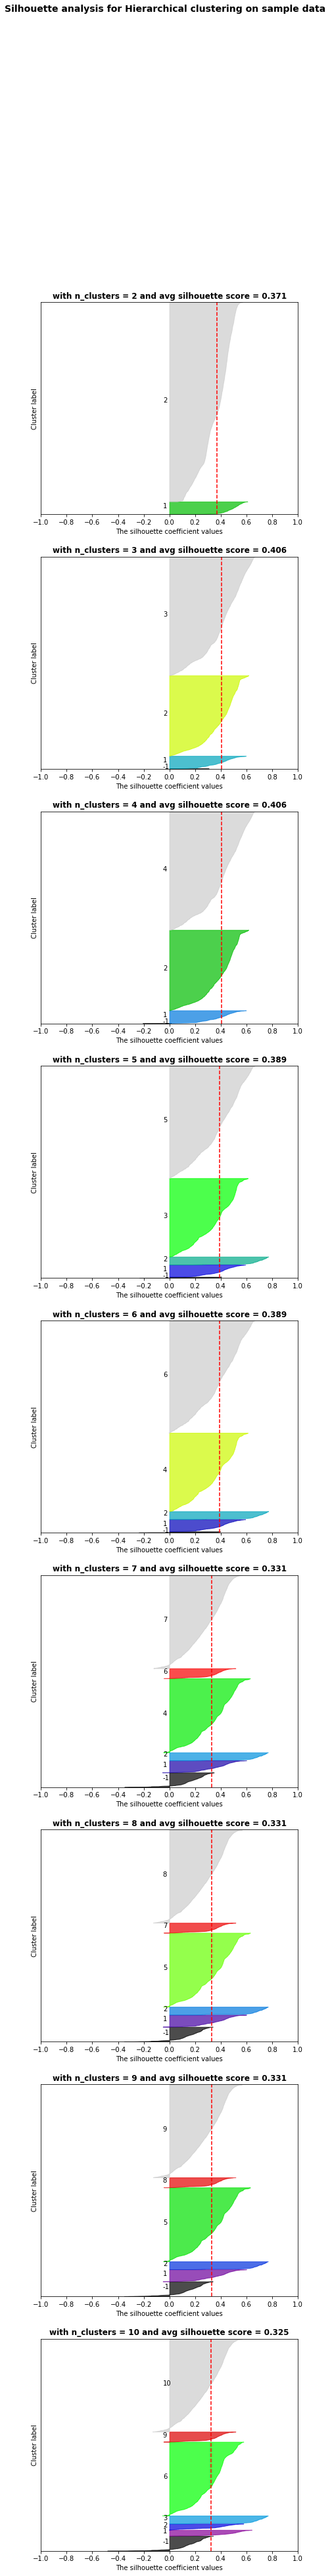

In [23]:
pictures_path = f"/content/drive/MyDrive/MIDA2/IntelligentMobilityProject/Pictures/{algo}/"
range_n_clusters = range(2, 11)
linkages = ["average"]

postprocessing = True
is_postprocessing = "_fix_v2" if postprocessing else ""

for link in linkages:
  print(f"Link: {link}")

  silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list = getSilhouetteFromRange(range_n_clusters, link=link, postprocessing=postprocessing)
  file_type = ".png"
  save_path = f"{pictures_path}Silhouette/{metric}{vars}{if_regions}/Silhouette_{link}_({range_n_clusters[0]},{range_n_clusters[-1]}){is_postprocessing}{file_type}"
  plot_silohuette_HC(range_n_clusters, silhouette_avg_list, sample_silhouette_values_list, cluster_labels_list, save_path)